In [2]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from suntime import Sun, SunTimeException
from datetime import datetime, timezone
import numpy as np
import glob
import os
import xarray as xr
from pathlib import Path
import gzip
import shutil
import matplotlib.pyplot as plt

In [2]:
####################### all functions ###########################

def sunlight_juelich(day, ds, time2):
    '''
    For the day it selects the timesteps with daylight (one hour after sunrise and one hour after sunrise)
    !! time dimension from dataset needs to be called time or time10s and time60s!!
    
    time2: use for datasets from the solarpanel, for the rest put time2 = None'''

    #coordinates of Juelich
    latitude = 50.9224
    longitude = 6.3639
    sun = Sun(latitude, longitude)
    
    #getting the time of sunrise +1 hour and the time of sunset - 1 hour. (result has information of timezone)
    sur_tzd = sun.get_local_sunrise_time(day) + timedelta(hours=1)
    sus_tzd = sun.get_local_sunset_time(day) - timedelta(hours=1)

    #delete timezonedesignator (Data from sup_joys are in UTC)
    sur = sur_tzd.replace(tzinfo=None)
    sus = sus_tzd.replace(tzinfo=None)
    if time2 == None:
        ds_light = ds.sel(time=slice(sur, sus))
    else:
        ds_light = ds.sel(time10s=slice(sur, sus), time60s=slice(sur, sus))
   
    return ds_light



def merge_lw_sw_datasets(startdate, enddate, outpath, outname):
    '''
    What does it?
    Step 4 from the Instructions:
    
    4. Saving data in array dataset instead of pandas data frame
        1. Iterate on a list of files from input
        2. Read also SW and LW downwelling, (as well as direct/diffuse SW radiation)
    
    
    -> In a timeperiod (between startdate and enddate) opens the daily datasets, puts all data (LW, LW_error, SW, SW_error) 
    into one dataset and selects the timstamps with sunlight.
    Saves it as a dataset in a given name and path. It creates new folders for every year if they do not already exist.
    
    
    input:
        - startdate: <string>: e.g.: '2020-01-01' 
        - enddate:   <string>: e.g.: '2020-03-02'
        - outpath:   <string>: where to save the nc-file eg.: 'full_datasets'
        - outname:   <string>: e.g.: 'all_data'  automaticlly appends the date of the day and an .nc at the end
        
        
    output:
        - saves a dataset (rlds, rlds_error, rsds, rsds_error), with the timesteps of the sunlight    
    ''' 
    #Range of the datas
    all_dates = pd.date_range(start=startdate,end=enddate)
    

    for day in all_dates:
        
        #get the day to string, to open the right file
        date = day.strftime('%Y%m%d') + '000000.nc'
        y = day.strftime('%Y')

        #Open Files for LW and shortwave data and put them in one dataset
         #getting the names from the data. Some names have ..._v00_... and some ..._v01...
        fileName_lw = glob.glob('/data/hatpro/jue/hdcp2/radiation_hdcp2/'+ y +'/sups_joy_pyrg00_l1_rlds_v*_'+ date )
        #if there is no file for the day it goes to the next day
        if not fileName_lw:
            print(date + ' no LW-file for this day found')
            continue

        #open files 
        fileObj_lw = Path(str(fileName_lw[0]))
        if fileObj_lw.is_file() == True:
            ds_lw = xr.open_dataset(str(fileName_lw[0]),
                                   drop_variables = ['lon', 'lat'])

        else: 
            print('File not found', fileName_lw[0])
            continue

        #getting the names from the data. Some names have ..._v00_... and some ..._v01...
        fileName_sw = glob.glob('/data/hatpro/jue/hdcp2/radiation_hdcp2/'+ y +'/sups_joy_pyr00_l1_rsds_v*_'+ date )
        #if there is no file for the day it goes to the next day
        if not fileName_sw:
            print(date + ' no SW-file for this day found')
            continue

        #open files 
        fileObj_sw = Path(str(fileName_sw[0]))
        if fileObj_sw.is_file() == True:
            ds_sw = xr.open_dataset(str(fileName_sw[0]))
        else: 
            print('File not found', fileName_sw[0])
            continue

        #put the sw data to the lw data
        ds_lw['rsds'] = ds_sw['rsds']
        ds_lw['rsds_error'] = ds_sw['rsds_error']
        ds = ds_lw
        
        #data with daylight
        ds_light = sunlight_juelich(day, ds, None)

        #checking if path/folder already exists
        MYDIR = (outpath + '/' + y)
        CHECK_FOLDER = os.path.isdir(MYDIR)

        # If folder doesn't exist, then create it.
        if not CHECK_FOLDER:
            os.makedirs(MYDIR)
            print("created folder : ", MYDIR)

        #saving it as a new dataset 
        save = outpath +'/'+ y + '/'+ outname + date 
        ds_light.to_netcdf(save)  

 

        
def merge_all_datasets(startdate, enddate, outpath, outname):
    '''
    merges the datasets of lw and sw in the given timerange.
    
    - outname: <string>: eg. 
    
    '''   
    inpath = 'full_datasets'
    inname = 'all_data'
    
    ds_merge = None
    #Range of the datas
    all_dates = pd.date_range(start=startdate,end=enddate)

    for day in all_dates:
        date = day.strftime('%Y%m%d') + '000000.nc'
        y = day.strftime('%Y')
        
        #open dataset
        fileName = inpath +'/'+ y + '/'+ inname + date 

        #open files 
        fileObj = Path(fileName)
        if fileObj.is_file() == True:
            ds = xr.open_dataset(fileName)
        else: 
            print('File not found', fileName)
            continue

        #print(ds_merge)
        if ds_merge is None:
            ds_merge = ds
        else:
            ds_merge = ds.merge(ds_merge)
        #except:
        #    print(f'doing ', day, 'could not merge! alarm!')
            
    #checking if path/folder already exists
    MYDIR = (outpath)
    CHECK_FOLDER = os.path.isdir(MYDIR)

    #If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        print("created folder : ", MYDIR)

    path_and_name = MYDIR + '/' + outname + '_' +  all_dates[0].strftime('%Y%m%d') + '_' + all_dates[len(all_dates)-1].strftime('%Y%m%d')  + '.nc'
    ds_merge.to_netcdf(path_and_name)  

    return ds

    


def data_quality(startdate, enddate, inpath, inname, outpath, outname):
    '''
    - you can choose a range of time, where it selects the datsets of the days where BOTH (LW and SW) Variables exists.
        (it uses the datasets which were created by the funct: merge_datasets)
    - checks the datasets for nan values (deletes the timesteps), unrealistic values (10<lw<700, -5<sw<1500 ???), and for gaps (non existent timesteps)
    - creates a dataframe from all days with the following information: starttime, endtime, length, how many timesteps
    - creates a dataset with all days where no dataset was found for
    
     input:
        - startdate: <string>: e.g.: '2020-01-01' 
        - enddate:   <string>: e.g.: '2020-03-02'
        - inname:    <string>: e.g.: 'all_data'  automaticlly appends the date of the day and an .nc at the end
        - inpath:    <string>: where to save the nc-file eg.: 'full_datasets'
        - outpath:   <string>: where to save the csv-file eg.: 'data_quality'
        - outname:   <string>: name of the pkl file (date is added): eg.: 'gaps' --> gaps_20200101_20200302.pkl
        
     output: 
        - saves gaps in a dataframe (starttime (the first missing), endtime (the last missing), length (counting one missing step as 5 sec), how many timesteps) as csv files (for each day)
    '''
    #Range of the datas
    all_dates = pd.date_range(start=startdate,end=enddate)
    ds_merge = None
    df_merge = None
    
    #coordinates of Juelich
    latitude = 50.908546
    longitude = 6.413536
    sun = Sun(latitude, longitude)
    
    # vektor for missing datasets 
    missing_dataset = np.full((len(all_dates)), 0)
    
    #loop backwards, because the df.merge, appends the dataframes on the top
    count = len(all_dates) - 1 
    for day in all_dates[::-1]:
        

        #get the day to string, to open the right file
        date = day.strftime('%Y%m%d') + '000000.nc'
        d = day.strftime('%d')
        m = day.strftime('%m')
        y = day.strftime('%Y')


        #Open Files for LW and shortwave data and put them in one dataset
         #getting the names from the data. Some names have ..._v00_... and some ..._v01...
        #fileName ='full_datasets/' + y + '/all_data' + date
        fileName = inpath +'/'+ y + '/'+ inname + date 
        
        #open files 
        fileObj = Path(fileName)
        if fileObj.is_file() == True:
            ds = xr.open_dataset(fileName)

        else: 
            print('File not found', fileName)
            #where datasets are missing put the value to -1
            missing_dataset[count] = -1
            count = count - 1
            continue
        count = count - 1



        #check if data values are realistic
        #lw
        ds['rlds_unrealistic_flag'] = (['time'], np.full((len(ds.rlds)), False))
        for i in range(0,len(ds.rlds)):
            if ds.rlds.values[i] > 700 or ds.rlds.values[i] < 10:
                ds.rlds_unrealistic_flag[i] = True 
                print('unrealistic rlds-values detected', day)

        #sw
        ds['rsds_unrealistic_flag'] = (['time'], np.full((len(ds.rsds)), False))
        for i in range(0, len(ds.rsds)):
            if ds.rsds.values[i] > 1500 or ds.rsds.values[i] < -5:
                ds.rsds_unrealistic_flag[i] = True 
                print('unrealistic rsds-values detected', day, print(ds.rsds.values[i]))



        #check for nan values
        ds['rlds_nan_flag'] = np.isnan(ds.rlds)
        if sum(ds['rlds_nan_flag'].data) > 0:
            print('nanrlds-Value detected', day)
            a = np.where(ds['rlds_nan_flag'] == True)
            print(len(a[0]), 'nan-rlds-Value detected', day, ds.time.values[a[0]])  
            #delete the timestamp with nan
            ds = ds.where(ds['rlds_nan_flag'] == False).dropna(how='all', dim='time')

        ds['rsds_nan_flag'] = np.isnan(ds.rsds)
        if sum(ds['rsds_nan_flag'].data) > 0:
            a = np.where(ds['rsds_nan_flag'] == True)
            print(len(a[0]), 'nan-rsds-Value detected', day, ds.time.values[a[0]])  
            #delete the timestamp with nan
            ds = ds.where(ds['rsds_nan_flag'] == False).dropna(how='all', dim='time')



        #check for gaps
        #create two lists with the timestamps, delete one object at the beginning and at the other list one at the end
        # substract the two list --> gaps length between one timestamp earlier and one later
        gap_end = ds.time.values
        gap_end = np.delete(gap_end, 0)
        gap_start = ds.time.values
        gap_start = np.delete(gap_start, len(gap_end)-1)

        gap_length = gap_end - gap_start
        
        #look where the gap is bigger than 5 seconds
        real_gaps = []
        #gives back the place of the gaps as a tuple
        real_gaps = np.where(gap_length > np.timedelta64(5000000000,'ns'))
        #print(real_gaps, len(real_gaps[0]), 'real_gaps')

        #if there are gaps, create a panda dataframe and save it
        #real_gaps is a tupel so len of the first vector
        if len(real_gaps[0]) > 0:

            gap_length_real = []
            gap_start_real = []
            gap_end_real = []
            missing_timestamps = []
            
            i = 0
            for i in range(0, len(real_gaps[0])):
                gap_length_real.append(gap_length[real_gaps[0][i]])
                gap_start_real.append(gap_start[real_gaps[0][i]])
                gap_end_real.append(gap_end[real_gaps[0][i]])
                missing_timestamps.append(gap_length[real_gaps[0][i]].astype('int64')/(5*10**9) -1)
                
            gap_start_real = gap_start_real +  np.timedelta64(5, 's')
            gap_end_real = gap_end_real -  np.timedelta64(5, 's')
            gap_length_real = gap_length_real - np.timedelta64(5, 's')
            
            #create dataframe and merge dataframes from all dates
            data = {'start_of_gap': gap_start_real, 'end_of_gap': gap_end_real, 'length_of_gap': gap_length_real, 'missing_timestamps': missing_timestamps}
            df = pd.DataFrame(data=data)

   
            if df_merge is None:
                df_merge = df
            else:
                df_merge = df.merge(df_merge, how= 'outer')
            #print(df_merge)
       
            
    #checking if path/folder already exists
    MYDIR = (outpath)
    CHECK_FOLDER = os.path.isdir(MYDIR)

    #If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        print("created folder : ", MYDIR)
        
    path_and_name = MYDIR + '/' + outname + '_' +  all_dates[0].strftime('%Y%m%d') + '_' + all_dates[len(all_dates)-1].strftime('%Y%m%d') 
        
    #save dataframe
    df_merge.to_pickle(path_and_name + '.pkl')
    
    #save as dataset: create dataset and save it as an nc-File
    ds_merge = df_merge.to_xarray()
    ds_merge.to_netcdf(path_and_name + '.nc') 
    
    #save the dates where no dataset was available:
    data_missing = {'days' :all_dates, 'missing_dataset': missing_dataset}
    df_missing = pd.DataFrame(data=data_missing)
    df_missing.to_pickle(MYDIR + '/missing_datasets_'+  all_dates[0].strftime('%Y%m%d') + '_' + all_dates[len(all_dates)-1].strftime('%Y%m%d') + '.pkl')

    
def gaps_per_day_in_a_year(year):
    
    '''
    What does it do?
        Plots the daily number of gaps in a year, when the plot is -1 then the dataset for the whole day is missing.
        Pre-condition: run the funct data_quality from 01-01 to 12-31 of the year 
    input: 
        - year: <string>  year 
    output: 
        - plot of the number of gaps'''
    
    startdate = year + '-01-01'
    enddate = year + '-12-31' 
    days = pd.date_range(start=startdate,end=enddate)


    # dataframes with gaps and missing days
    df_gaps = pd.read_pickle('data_quality/' + 'gaps_' + year + '0101_' + year + '1231.pkl')  
    df_miss_dataset = pd.read_pickle('data_quality/' + 'missing_datasets_'+year+'0101_'+year+'1231.pkl')  


    a = []
    df_gaps['date_of_gap'] = np.zeros(len(df_gaps['start_of_gap']))
    for i in range(0, len(df_gaps['start_of_gap'])):
        a.append(df_gaps['start_of_gap'][i].replace(hour=0, minute=0, second=0))
    df_gaps['date_of_gap'] = a


    number_of_gaps = df_miss_dataset['missing_dataset']
    for d in range(0, len(days)):
        for g in range(0,len(df_gaps['date_of_gap'])):
            if df_gaps['date_of_gap'][g] == days[d]:
                #print(df_gaps['date_of_gap'][g], days[d])
                number_of_gaps[d] = number_of_gaps[d] + 1


    data = {'day': days, 'number_of_gaps' : number_of_gaps}
    df = pd.DataFrame(data=data)   
    ax = df.plot(kind = 'scatter', x = 'day', y = 'number_of_gaps', figsize=(15,5))
    ax.set_title('Daily number of gaps in ' + year +' , -1 => whole day is missing')
    ax.set_ylabel('Number of gaps')
    ax.set_xlabel('Time')
    
    plt.show() 

In [3]:
#run data_quality function to work with the result from it

startdate = '2019-01-01'
enddate = '2019-12-31'
inpath = 'full_datasets'
inname =  'all_data' 
outpath = 'data_quality'
outname = 'gaps'
data_quality(startdate, enddate, inpath, inname, outpath, outname)

3 nan-rsds-Value detected 2019-07-25 00:00:00 ['2019-07-25T20:06:13.000000000' '2019-07-25T20:06:18.000000000'
 '2019-07-25T20:06:33.000000000']
82 nan-rsds-Value detected 2019-07-22 00:00:00 ['2019-07-22T20:02:28.000000000' '2019-07-22T20:02:33.000000000'
 '2019-07-22T20:02:38.000000000' '2019-07-22T20:02:43.000000000'
 '2019-07-22T20:02:48.000000000' '2019-07-22T20:02:53.000000000'
 '2019-07-22T20:02:58.000000000' '2019-07-22T20:03:03.000000000'
 '2019-07-22T20:03:08.000000000' '2019-07-22T20:03:13.000000000'
 '2019-07-22T20:03:18.000000000' '2019-07-22T20:03:23.000000000'
 '2019-07-22T20:03:28.000000000' '2019-07-22T20:03:33.000000000'
 '2019-07-22T20:03:38.000000000' '2019-07-22T20:03:43.000000000'
 '2019-07-22T20:03:48.000000000' '2019-07-22T20:03:53.000000000'
 '2019-07-22T20:03:58.000000000' '2019-07-22T20:04:03.000000000'
 '2019-07-22T20:04:08.000000000' '2019-07-22T20:04:13.000000000'
 '2019-07-22T20:04:18.000000000' '2019-07-22T20:04:23.000000000'
 '2019-07-22T20:04:28.000000

### Plot the lw and sw in a historgram ###
all data, without filters

In [3]:
startdate = '2018-01-01'
enddate = '2018-12-31'

merge_all_datasets(startdate, enddate, 'merged_dataset', 'merged')

KeyboardInterrupt: 

##### 2018 ######

5th percentile of rlds (longwaveradiation) :  278.29998779296875
95th percentile of rlds (longwaveradiation) :  400.20001220703125


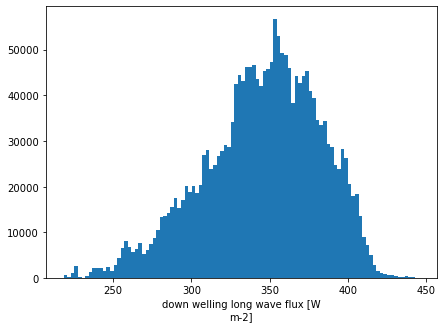

In [4]:
#2018 longwave
ds_2018 = xr.open_dataset('merged_dataset/' + 'merged_20180101_20181231.nc')  


ax = ds_2018['rlds'].plot.hist(figsize=(7,5), bins = 100)
#ax.set_xlabel("length of the gaps [min]")
#ax.set_title('Histogram of gaps in the year 2018')

print("5th percentile of rlds (longwaveradiation) : ",
       np.percentile(ds_2018.rlds.values, 5))
print("95th percentile of rlds (longwaveradiation) : ",
       np.percentile(ds_2018.rlds.values, 95))

5th percentile of rlds (shortwaveradiation):  0.5
95th percentile of rlds (shortwaveradiation):  863.0


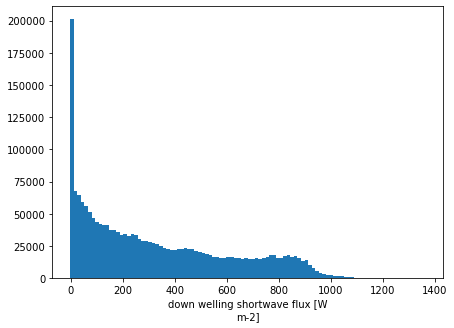

In [6]:
#2018 shortwaveradiation
ds_2018 = xr.open_dataset('merged_dataset/' + 'merged_20180101_20181231.nc')  
ds_2018['rlds_nan_flag'] = np.isnan(ds_2018.rlds)
ds_2018 = ds_2018.where(ds_2018['rlds_nan_flag'] == False).dropna(how='all', dim='time')


ax = ds_2018['rsds'].plot.hist(figsize=(7,5), bins = 100)
ax.set_ylabel("frequency")


print("5th percentile of rlds (shortwaveradiation): ",
       np.nanpercentile(ds_2018.rsds.values, 5))
print("95th percentile of rlds (shortwaveradiation): ",
       np.nanpercentile(ds_2018.rsds.values, 95))

##### 2019 #####

5th percentile of rlds (longwaveradiation) :  261.0
95th percentile of rlds (longwaveradiation) :  395.29998779296875


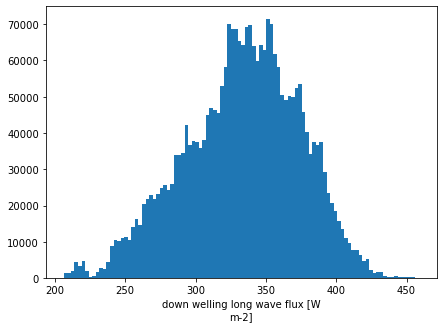

In [91]:
#2019 longwave
ds_2019 = xr.open_dataset('merged_dataset/' + 'merged_20190101_20191231.nc')  


ax = ds_2019['rlds'].plot.hist(figsize=(7,5), bins = 100)
ax.set_ylabel("frequency")


print("5th percentile of rlds (longwaveradiation) : ",
       np.percentile(ds_2019.rlds.values, 5))
print("95th percentile of rlds (longwaveradiation) : ",
       np.percentile(ds_2019.rlds.values, 95))

5th percentile of rlds (shortwaveradiation):  0.10000000149011612
95th percentile of rlds (shortwaveradiation):  831.2999877929688


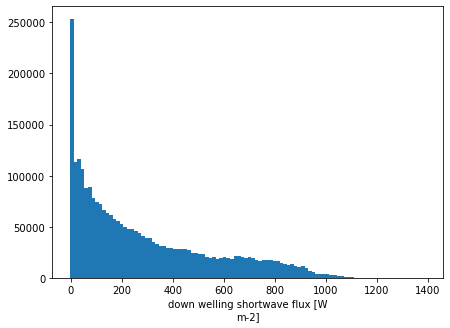

In [6]:
#2019 shortwaveradiation
ds_2019 = xr.open_dataset('merged_dataset/' + 'merged_20190101_20191231.nc')  


ax = ds_2019['rsds'].plot.hist(figsize=(7,5), bins = 100)
#ax.set_xlabel("length of the gaps [min]")
#ax.set_title('Histogram of gaps in the year 2018')

print("5th percentile of rlds (shortwaveradiation): ",
       np.nanpercentile(ds_2019.rsds.values, 3))
print("95th percentile of rlds (shortwaveradiation): ",
       np.nanpercentile(ds_2019.rsds.values, 95))

### Plot of the length of gaps of the data in a histogram ###


In [28]:
#help(data_quality)
startdate = '2019-01-01'
enddate = '2019-12-31'
data_quality(startdate, enddate, 'full_datasets', 'all_data', 'data_quality', 'gaps')

KeyboardInterrupt: 

Text(0.5, 1.0, 'Histogram of the length of gaps in the year 2018')

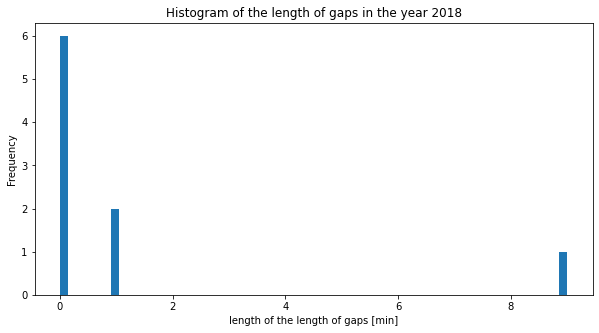

In [29]:
#2018
df_2018 = pd.read_pickle('data_quality/' + 'gaps_20180101_20181231.pkl')  
df_2018['length_of_gap']

ax = df_2018['length_of_gap'].astype('timedelta64[m]').plot.hist(figsize=(10,5),bins = 60 )
ax.set_xlabel("length of the length of gaps [min]")
ax.set_title('Histogram of the length of gaps in the year 2018')


Text(0.5, 1.0, 'Histogram of the length of gaps in the year 2019')

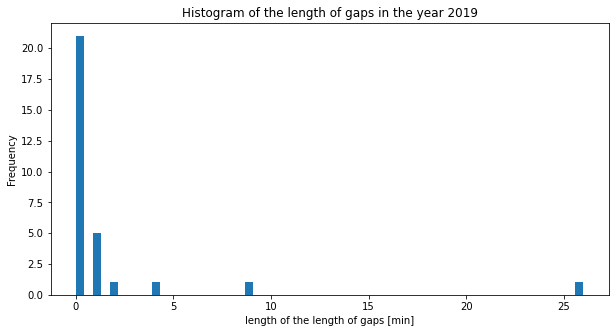

In [30]:
#2019 
df_2019 = pd.read_pickle('data_quality/' + 'gaps_20190101_20191231.pkl')  
df_2019['length_of_gap']
ax = df_2019['length_of_gap'].astype('timedelta64[m]').plot.hist(figsize=(10,5),bins = 60)
ax.set_xlabel("length of the length of gaps [min]")
ax.set_title('Histogram of the length of gaps in the year 2019')

### monthly timeseries with gaps per day ###

In [26]:
#%matplotlib inline
#import ipywidgets as widgets



/tmp/ipykernel_1993196/2143357989.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_gaps[d] = number_of_gaps[d] + 1


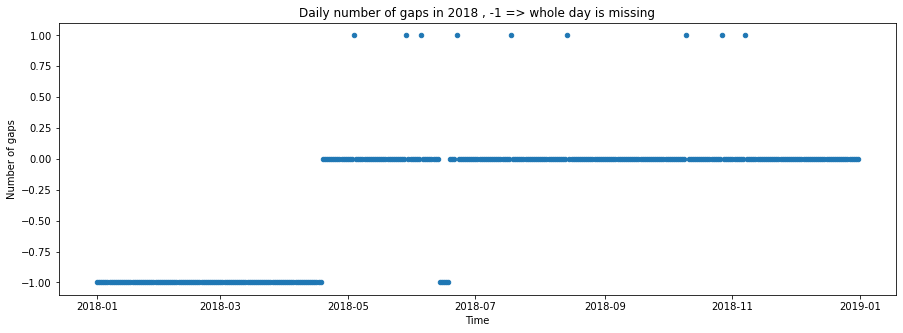

In [27]:
gaps_per_day_in_a_year('2018')

/tmp/ipykernel_1993196/3510068300.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_of_gaps[d] = number_of_gaps[d] + 1


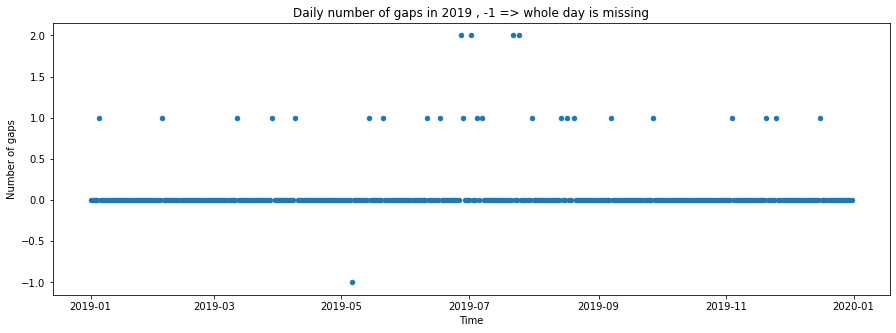

In [23]:
gaps_per_day_in_a_year('2019')